In [10]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import statsmodels.api as sm
from fredapi import Fred
from edgar import Company, Edgar
from xbrl import XBRLParser

pd.set_option('display.max_rows',100)

fred_key = '3e34548a3e5cb0ec6865f9c8e7e398bf'

In [2]:
def get_stock_data(ticker, start, end):
    stock = yf.Ticker(ticker)
    data = stock.history(start = start, end = end, interval='1d')
    data.index = pd.to_datetime(data.index)
    data.index = data.index.normalize()
    data.index = data.index.tz_localize(None)
    return data


In [3]:
aapl = get_stock_data("AAPL","2000-01-01","2023-06-01")
aapl.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)

aapl['returns'] = np.log(aapl.Close/aapl.Close.shift(1))
aapl['histVars'] = np.var(aapl['returns'], ddof=1)
aapl['histVol']= np.sqrt(aapl['histVars'])

In [5]:
spx = get_stock_data("^GSPC","2000-01-01","2023-06-01")

spx.drop(columns = ['Open', 'High','Low','Dividends', 'Stock Splits'], inplace = True)
spx.rename(columns=lambda x: 'spx_' + x, inplace = True)

In [6]:
data = aapl.join(spx, how = 'left')

In [8]:
fred = Fred(api_key=fred_key)

series_ids = {
    'crude_oil_prices': 'DCOILWTICO',
    'cpi': 'CPIAUCSL',
    'unrate': 'UNRATE',
    'ffr': 'FEDFUNDS',
    'mp': 'IPMAN',
    'consumer_sentiment': 'UMCSENT',
    'retail_sales': 'RSAFS',
    'industrial_production': 'INDPRO',
    'housing_starts': 'HOUST',
    'corporate_profits': 'CP',
    'treasury_rate_10y': 'GS10',
    'gdp': 'GDP',
}

start = "2000-01-01"
end = "2023-06-01"

economic_data = pd.DataFrame()

for name, fetch in series_ids.items():
    series = fred.get_series(fetch,start=start, end=end)
    series = series.asfreq('B', method='ffill')  # resample to business daily frequency
    series.name = name
    if economic_data.empty:
        economic_data = series.to_frame()
    else:
        economic_data = economic_data.join(series, how = 'left')

# Now economic_data is a DataFrame that includes all the economic indicators at daily frequency.
economic_data.index = pd.to_datetime(economic_data.index)
economic_data.index = economic_data.index.tz_localize(None)
economic_data = economic_data[start:end]

economic_data.fillna(method='ffill', inplace=True)


In [9]:
data = data.join(economic_data, how = 'left')
display(data)

,Open,High,Low,Close,Volume,returns,histVars,histVol,spx_Close,spx_Volume,...,unrate,ffr,mp,consumer_sentiment,retail_sales,industrial_production,housing_starts,corporate_profits,treasury_rate_10y,gdp
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.795873,0.853737,0.771683,0.849469,535796800,NaN,0.000669,0.025861,1455.219971,931800000,...,4.0,5.45,92.0231,112.0,268044.0,91.4251,1636.0,527.574,6.66,10002.179
2000-01-04,0.821485,0.839508,0.767889,0.777849,512377600,-0.088078,0.000669,0.025861,1399.420044,1009000000,...,4.0,5.45,92.0231,112.0,268044.0,91.4251,1636.0,527.574,6.66,10002.179
2000-01-05,0.787335,0.839034,0.781644,0.789232,778321600,0.014527,0.000669,0.025861,1402.109985,1085500000,...,4.0,5.45,92.0231,112.0,268044.0,91.4251,1636.0,527.574,6.66,10002.179
2000-01-06,0.805359,0.811999,0.720933,0.720933,767972800,-0.090514,0.000669,0.025861,1403.449951,1092300000,...,4.0,5.45,92.0231,112.0,268044.0,91.4251,1636.0,527.574,6.66,10002.179
2000-01-07,0.732317,0.766466,0.724728,0.755083,460734400,0.046281,0.000669,0.025861,1441.469971,1225200000,...,4.0,5.45,92.0231,112.0,268044.0,91.4251,1636.0,527.574,6.66,10002.179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,171.089996,172.419998,170.520004,171.839996,45143500,0.001631,0.000669,0.025861,4115.240234,3739160000,...,3.7,5.06,100.5996,62.0,686573.0,103.0107,1371.0,2721.294,3.57,26137.992
2023-05-25,172.410004,173.899994,171.690002,172.990005,56058300,0.006670,0.000669,0.025861,4151.279785,4147760000,...,3.7,5.06,100.5996,62.0,686573.0,103.0107,1371.0,2721.294,3.57,26137.992
2023-05-26,173.320007,175.770004,173.110001,175.429993,54835000,0.014006,0.000669,0.025861,4205.450195,3715460000,...,3.7,5.06,100.5996,62.0,686573.0,103.0107,1371.0,2721.294,3.57,26137.992


In [9]:
stock = "ORLY"
ticker = yf.Ticker(stock)

options = ['2023-06-16',
 '2023-07-21',
 '2023-08-18',
 '2023-11-17',
 '2024-01-19',
 '2024-06-21']

calls = {}
puts = {}

orly = get_hist_stock(ticker)
hist_calc = orly
hist_calc['returns'] = np.log(hist_calc.Close/hist_calc.Close.shift(1))
hist_calc['histVars'] = np.var(hist_calc['returns'], ddof=1)
hist_calc['histVol']= np.sqrt(hist_calc['histVars'])

NameError: name 'get_hist_stock' is not defined

In [ ]:
# Iterate over the exercise dates. this is creating dicts with the keys as their dates
for date in options:
    # Fetch the option chain for the current date
    opt = ticker.option_chain(str(date))

    # Create a DataFrame for the current exercise date
    calls[str(date)] = pd.DataFrame(opt.calls)
    puts[str(date)] = pd.DataFrame(opt.puts)

# Reading calls and puts into their own dataframes and assigning    
calls_df = pd.concat({k: v.assign(contractDate = k) for k, v in calls.items()}, ignore_index=True)
puts_df = pd.concat({k: v.assign(contractDate = k) for k, v in puts.items()}, ignore_index=True)

puts_df['lastTradeDate'] = pd.to_datetime(puts_df['lastTradeDate'])
puts_df.set_index('lastTradeDate', inplace=True)


calls_df['lastTradeDate'] = pd.to_datetime(calls_df['lastTradeDate'])
calls_df.set_index('lastTradeDate', inplace=True)

# Resample the options data to daily frequency, taking the mean of the implied volatility each day.
iv_calls = calls_df['impliedVolatility'].resample('D').mean()
iv_calls = iv_calls.to_frame()
# Rename the column
iv_calls = iv_calls.rename(columns={'impliedVolatility': 'iv_calls'})


iv_puts = puts_df['impliedVolatility'].resample('D').mean()
iv_puts = iv_puts.to_frame()
# Rename the column
iv_puts = iv_puts.rename(columns={'impliedVolatility': 'iv_puts'})

iv_calls.index = iv_calls.index.strftime('%Y-%m-%d')
iv_puts.index = iv_puts.index.strftime('%Y-%m-%d')


In [ ]:
hist_calc = hist_calc.merge(iv_puts, how='left', left_index=True, right_index=True)
hist_calc = hist_calc.merge(iv_calls, how='left', left_index=True, right_index=True)

In [ ]:

df = hist_calc.loc[hist_calc.index >'2022-01-07']
df = df.bfill()

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,histVars,histVol,iv_puts,iv_calls
Date,,,,,,,,,,,,
2022-01-10,681.719971,681.719971,664.440002,675.080017,456700,0.0,0.0,-0.010565,0.000449,0.021181,0.509298,0.000010
2022-01-11,673.359985,681.869995,664.940002,681.599976,408500,0.0,0.0,0.009612,0.000449,0.021181,0.509298,0.000010
2022-01-12,683.270020,687.500000,678.530029,683.599976,354200,0.0,0.0,0.002930,0.000449,0.021181,0.509298,0.000010
2022-01-13,692.960022,693.669983,685.119995,687.739990,292100,0.0,0.0,0.006038,0.000449,0.021181,0.509298,0.000010
2022-01-14,692.460022,692.789978,674.770020,678.869995,590500,0.0,0.0,-0.012981,0.000449,0.021181,0.509298,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,896.690002,905.070007,896.159973,902.109985,431600,0.0,0.0,0.007533,0.000449,0.021181,0.349677,0.215870
2023-06-06,902.289978,902.289978,875.059998,885.929993,599600,0.0,0.0,-0.018099,0.000449,0.021181,0.292385,0.297309
2023-06-07,884.000000,899.840027,880.059998,883.109985,545500,0.0,0.0,-0.003188,0.000449,0.021181,0.346142,0.357388


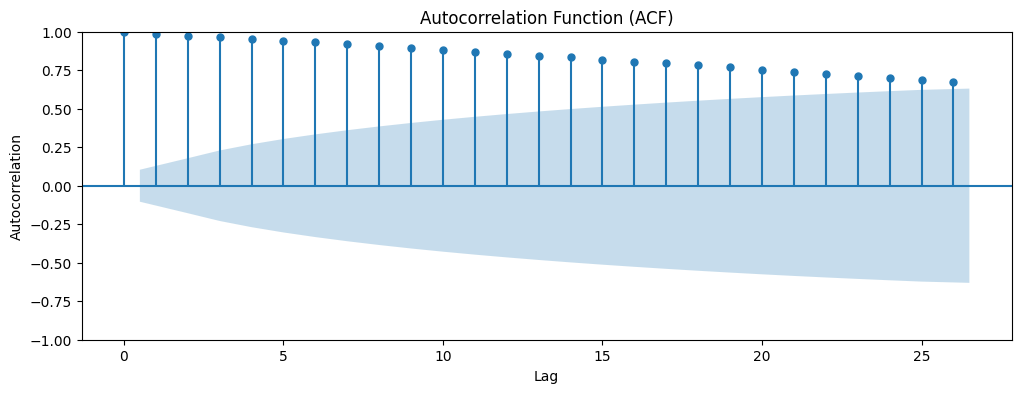

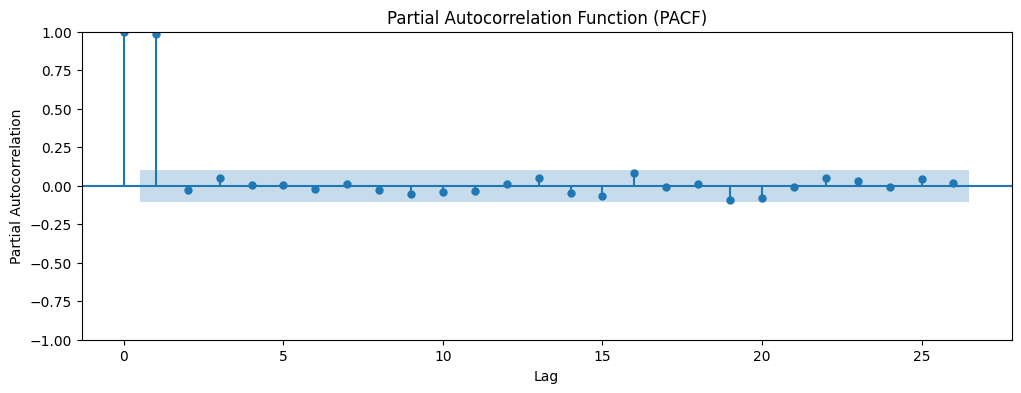

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)
fig, ax = plt.subplots(figsize=(12, 4))
df1 = df.diff().dropna()
plot_acf(df['Close'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(df['Close'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Identify the model order (p, d, q) and seasonal order (P, D, Q, s) based on the ACF and PACF plots
# ...


In [ ]:
# Assuming your DataFrame is named 'df' and you want to set a new date index

# Create a new date range with the desired frequency
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Truncate or subset the new index to match the length of the DataFrame
new_index = new_index[:len(df)]

# Assign the new index to the DataFrame
df.index = new_index


# Prepare the endogenous data
endog = df['Close']

# Prepare the exogenous data
exog = df[['returns', 'High']]  # add more exogenous variables as needed

# Define the model
model = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(0,2,1))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25132D+00    |proj g|=  3.74377D-01

At iterate    5    f=  3.05862D+00    |proj g|=  1.47644D-02

At iterate   10    f=  3.04099D+00    |proj g|=  6.16829D-03

At iterate   15    f=  3.03864D+00    |proj g|=  6.63442D-03

At iterate   20    f=  3.03753D+00    |proj g|=  5.01768D-03

At iterate   25    f=  3.03598D+00    |proj g|=  6.54143D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

 This problem is unconstrained.


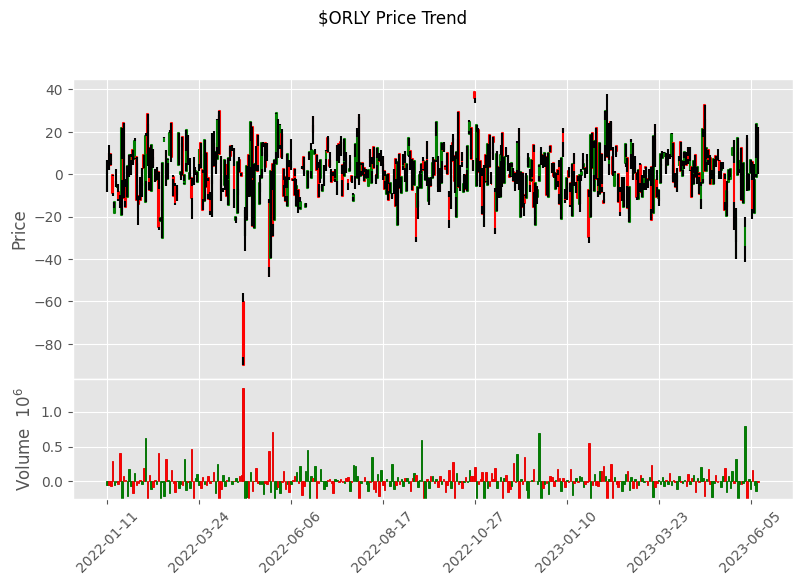

[*********************100%***********************]  2 of 2 completed


In [ ]:
hist1 = df.loc[df.index >'2022-01-01']
hist1 = hist1.diff().dropna()
# Convert index to DatetimeIndex
hist1.index = pd.to_datetime(hist1.index)
# hist1.set_index('Date', inplace=Tarue)

# Set the style and customization options
mc = mpf.make_marketcolors(up='g', down='r', edge='inherit', volume='in')
s = mpf.make_mpf_style(base_mpl_style='ggplot', marketcolors=mc)

# Create the plot
mpf.plot(hist1, type='candle', style=s, title='$ORLY Price Trend',
         ylabel='Price', volume=True, figratio=(10, 6), figsize=(10, 6),
         datetime_format='%Y-%m-%d', xrotation=45, update_width_config=dict(candle_linewidth=1.5))

# Show the plot
mpf.show()

#reads in apple and nasdaq historical info
data = yf.download("NDAQ AAPL", period = '1y', prepost=True, repair=True)

